### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/opc/davidres/retina/mbrset/data'
DOWNLOAD = False
SHAPE = (384, 384)
IMAGES = os.path.join(DATASET, 'mBRSET/')
LABEL = 'sex'
TEST_SIZE = 0.3
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'file'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

BACKBONE = 'dinov-large'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 6
NUM_WORKERS = 4

LOSS = 'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df = df[df['file'] != '985.1.jpg'] # this is missing
df = df.dropna(subset=['sex'])
df.head()

loading csv file in /home/chenweiw/retina/mbrset/data/labels.csv


,patient,age,sex,dm_time,insulin,insulin_time,oraltreatment_dm,systemic_hypertension,insurance,educational_level,...,nephropathy,neuropathy,diabetic_foot,file,laterality,final_artifacts,final_quality,final_icdr,final_edema,normality
0,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.1.jpg,right,yes,yes,4.0,no,abnormal
1,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.2.jpg,right,yes,yes,4.0,no,abnormal
2,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.3.jpg,left,yes,yes,4.0,no,abnormal
3,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.4.jpg,left,yes,yes,4.0,no,abnormal
4,10,63,0,7.0,0.0,NaN,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,10.1.jpg,right,yes,yes,0.0,no,abnormal


In [4]:
# Convert into 2 classes:

# Normal = 0; Non-proliferative = 1, 2, 3; Proliferative = 4
# for binary: 0: normal, 1-4: abnormal
# Map values to categories
df[LABEL] = df[LABEL].astype(int)

df[LABEL] = df[LABEL].apply(lambda x: '1' if x == 1 else '0' )
print(df[LABEL].value_counts())

0    3359
1    1804
Name: sex, dtype: int64


Train data shape: (3614, 25)
Test data shape: (1549, 25)


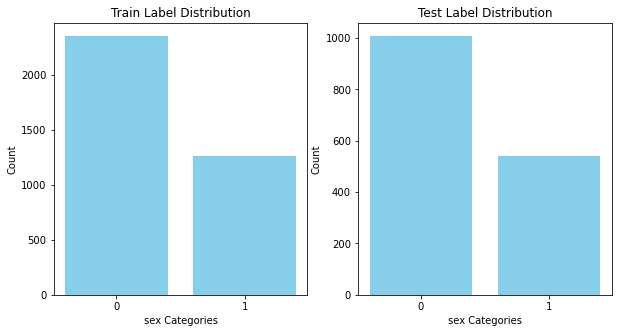

Getting validation set...


In [5]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_val = df_test

### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [7]:
# Define the target image shape
SHAPE = (384, 384)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize(SHAPE),
    # transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    # transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [8]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


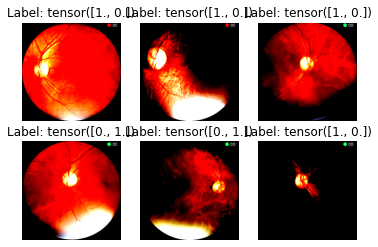

In [9]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [10]:
# Create a DataLoader to generate embeddings
#model = get_retfound(weights='/scratch/liyues_root/liyues/chenweiw/retina_datasets/retfound_weigths/RETFound_cfp_weights.pth', num_classes=3)
# Create a DataLoader to generate embeddings
from transformers import ConvNextV2Model, ConvNextV2ForImageClassification
import torch

# Load the pre-trained ConvNeXt V2 model
model_name = "facebook/convnextv2-large-22k-384"
model = ConvNextV2ForImageClassification.from_pretrained(model_name)

# Modify the classifier head according to the new number of classes
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

### Training:

In [11]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Class distribution: [2351 1263]


In [ ]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'{BACKBONE}_{num_classes}class_{LABEL}')

100%|██████████| 1549/1549 [00:21<00:00, 73.01it/s]


Epoch 1, Train Loss: 0.07637715728252285, Val Loss: 0.06983848115437699, F1 Score: 0.5891781260633719, acc0.5894125242091672
cm[[438 570]
 [ 66 475]]


100%|██████████| 1549/1549 [00:21<00:00, 73.27it/s]


Epoch 2, Train Loss: 0.057919411689883245, Val Loss: 0.05837511081422731, F1 Score: 0.7338851899768248, acc0.7469335054874112
cm[[750 258]
 [134 407]]


100%|██████████| 1549/1549 [00:21<00:00, 72.96it/s]


Epoch 3, Train Loss: 0.03123059110223392, Val Loss: 0.07310760780570212, F1 Score: 0.7534816226735102, acc0.775984506132989
cm[[835 173]
 [174 367]]


100%|██████████| 1549/1549 [00:21<00:00, 72.68it/s]


Epoch 4, Train Loss: 0.01430101561273715, Val Loss: 0.05753926120574606, F1 Score: 0.8026572026572028, acc0.8192382182052937
cm[[859 149]
 [131 410]]


100%|██████████| 1549/1549 [00:21<00:00, 72.69it/s]


Epoch 5, Train Loss: 0.005250820269228015, Val Loss: 0.09128864656010471, F1 Score: 0.7936405395968122, acc0.816010329244674
cm[[887 121]
 [164 377]]


100%|██████████| 1549/1549 [00:21<00:00, 73.00it/s]


Epoch 6, Train Loss: 0.00025833891261115103, Val Loss: 0.1377166553763336, F1 Score: 0.8002332832758245, acc0.8256939961265333
cm[[916  92]
 [178 363]]


100%|██████████| 1549/1549 [00:21<00:00, 73.19it/s]


Epoch 7, Train Loss: 3.155942853461047e-05, Val Loss: 0.1335649981665448, F1 Score: 0.8075681681273426, acc0.828921885087153
cm[[900 108]
 [157 384]]


100%|██████████| 1549/1549 [00:21<00:00, 73.26it/s]


Epoch 8, Train Loss: 1.4479260363022633e-05, Val Loss: 0.13764811505829813, F1 Score: 0.8083043444352758, acc0.828921885087153
cm[[896 112]
 [153 388]]


100%|██████████| 1549/1549 [00:21<00:00, 72.87it/s]


Epoch 9, Train Loss: 8.679860944054958e-06, Val Loss: 0.1458016793964428, F1 Score: 0.8054837089349707, acc0.8269851517107811
cm[[898 110]
 [158 383]]


 94%|█████████▍| 1457/1549 [00:19<00:01, 73.98it/s]

### Test

In [ ]:
test(model, test_dataloader, saliency=True, device=device)

### Image quality assessment

In [ ]:
# Good quality images
adequate_df = df_test[df_test['final_quality'] == 'yes']

# Bad quality images
inadequate_df = df_test[df_test['final_quality'] == 'no']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

In [ ]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

In [ ]:
test(model, inadequate_dataloader, saliency=True, device=device)